# Simulation and figure generation for differential correlation

In [54]:
import scipy.stats as stats
import scipy.sparse as sparse
from scipy.stats import norm, gamma, poisson, nbinom
import numpy as np
from mixedvines.copula import Copula, GaussianCopula, ClaytonCopula, \
        FrankCopula
from mixedvines.mixedvine import MixedVine
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import scanpy as sc
%matplotlib inline
import imp
import seaborn as sns

In [41]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/examples/simulation/')
import simulate as sim

In [42]:
data_path = '/data/parameter_estimation/interferon_data/'

In [43]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [44]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


### Function for converting params

In [45]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

### Function for plotting 2D discrete scatter plots

In [46]:
def plot_2d_discrete(data, size_multiplier=10, offset=0.0):
    """ Plotting discrete 2D data according to the frequency. """
    
    df = pd.DataFrame(data).groupby([0, 1]).size().reset_index(name='count')
    df['log_count'] = np.log(df['count'])
    
    plt.scatter(df[0]+offset, df[1]+offset, s=df['log_count']*size_multiplier)    
    

### Simulation

In [47]:
def simulate_correlated_data(corr, size=1000):
    
    dim = 2  # Dimension
    vine = MixedVine(dim)

    vine.set_marginal(0, nbinom(*convert_params(3, 10)))
    vine.set_marginal(1, nbinom(*convert_params(3, 10)))
    vine.set_copula(1, 0, GaussianCopula(corr))
    samples = vine.rvs(size)
    
    return samples.astype(int)

def simulate_dropout(
    true_counts,
    q,
    q_sq):
    """ 
        :true_counts: True counts
        :q: first moment of the dropout probability
        :q_sq: second moment of the dropout probability

        Simulate the beta-binomial dropout.
    """

    m = q
    v = q_sq - q**2
    alpha = m*(m*(1-m)/v - 1)
    beta = (1-m)*(m*(1-m)/v - 1)
    qs = stats.beta.rvs(alpha, beta, size=true_counts.shape[0])

    return qs, stats.binom.rvs(true_counts, np.vstack([qs for i in range(true_counts.shape[1])]).T)


def create_simulated_anndata(samples):
    
    N = samples.shape[0]
    obs_df = pd.DataFrame()
    obs_df['n_counts'] = [1e10 for i in range(N)]
    #obs_df['cell_type'] = label
    values = samples
    adata = sc.AnnData(
        values, 
        var=pd.DataFrame(index=['gene_' + str(i) for i in range(1, n_genes+1)]),
        obs=obs_df)
    
    return adata

In [108]:
N = 20000
n_genes=2
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
samples_A = simulate_correlated_data(0.7, size=N)
samples_B = simulate_correlated_data(0.01, size=N)

In [109]:
qs_A, obs_samples_A = simulate_dropout(samples_A, p, p_sq)
qs_B, obs_samples_B = simulate_dropout(samples_B, p, p_sq)
adata = create_simulated_anndata(np.vstack([obs_samples_A, obs_samples_B]))
adata.obs['cell_type'] = ['A' for i in range(N)] + ['B' for i in range(N)]

Transforming to str index.


### Estimate correlation

In [110]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=100000,
    beta=p)
estimator.beta_sq = p_sq


In [111]:
estimator.compute_observed_moments('A')
estimator.compute_observed_moments('-A')
estimator.compute_observed_moments('B')
estimator.compute_observed_moments('-B')    
estimator.estimate_parameters()

estimator.compute_confidence_intervals_1d(
    groups=['A','B'],
    groups_to_compare=[('A', 'B')])

estimator.compute_confidence_intervals_2d(
    gene_list_1=['gene_1'],
    gene_list_2=['gene_2'],
    groups=['A', 'B'],
    groups_to_compare=[('A', 'B')])

Computing the 0st/th gene
Computing the 0st/th gene of 1


### Plotting simulation results

In [112]:
def line_from_correlation(corr, corr_ci, x, y, mu_x, mu_y, sigma_x, sigma_y, color_order):
    
#     mu_x = x.mean()
#     mu_y = y.mean()
#     sigma_x = x.std()
#     sigma_y = y.std()
    
    beta_up = sigma_y/sigma_x*(corr + corr_ci)
    alpha_up = mu_y - beta_up*mu_x
    
    beta = sigma_y/sigma_x*(corr)
    alpha = mu_y - beta*mu_x
    
    beta_down = sigma_y/sigma_x*(corr - corr_ci)
    alpha_down = mu_y - beta_down*mu_x
    
    x_range = np.arange(x.min(), 7, 0.1)
    
    up = beta_up*x_range + alpha_up
    line = beta*x_range + alpha
    down = beta_down*x_range + alpha_down
            
    plt.fill_between(x_range, up, down, alpha=0.3, color=sns.color_palette()[color_order])
    plt.plot(x_range, line, color=sns.color_palette()[color_order])

In [114]:
print(stats.pearsonr(samples_A[:, 0], samples_A[:, 1]))
print(stats.pearsonr(samples_B[:, 0], samples_B[:, 1]))

(0.672285234671457, 0.0)
(0.004221666995649047, 0.5505079037459575)


In [115]:
print(stats.pearsonr(obs_samples_A[:, 0], obs_samples_A[:, 1]))
print(stats.pearsonr(obs_samples_B[:, 0], obs_samples_B[:, 1]))

(0.14932774572499713, 4.4436330666480366e-100)
(0.05330081734332394, 4.601119057764495e-14)


In [113]:
print(estimator.parameters['A']['corr'][0, 1])
print(estimator.parameters['B']['corr'][0, 1])

0.6411546401792025
-0.00719602004287112


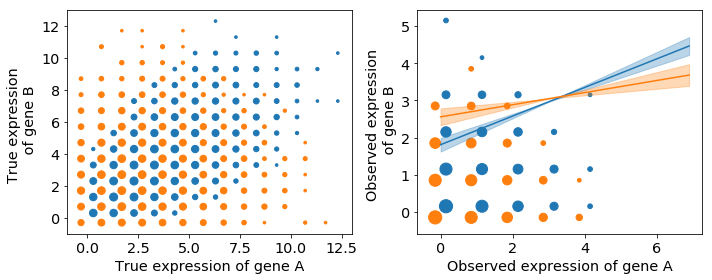

In [76]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1);
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

plot_2d_discrete(samples_A, 10, 0.3)
plot_2d_discrete(samples_B, 10, -0.3)
plt.xlim(-1, 13)
plt.ylim(-1, 13)
plt.ylabel('True expression \n of gene B');
plt.xlabel('True expression of gene A');

plt.subplot(1, 2, 2);

plot_2d_discrete(obs_samples_A, 20, 0.15)
plot_2d_discrete(obs_samples_B, 20, -0.15)


line_from_correlation(
    corr=estimator.parameters['A']['corr'][0, 1],
    corr_ci=estimator.parameters_confidence_intervals['A']['corr'][0, 1],
    x=obs_samples_A[:, 0],
    y=obs_samples_A[:, 1],
    mu_x=estimator.parameters['A']['mean'][0],
    mu_y=estimator.parameters['A']['mean'][1],
    sigma_x=estimator.estimated_central_moments['A']['second'][0],
    sigma_y=estimator.estimated_central_moments['A']['second'][1],
    color_order=0
    )
line_from_correlation(
    corr=estimator.parameters['B']['corr'][0, 1],
    corr_ci=estimator.parameters_confidence_intervals['B']['corr'][0, 1],
    x=obs_samples_B[:, 0],
    y=obs_samples_B[:, 1],
    mu_x=estimator.parameters['B']['mean'][0],
    mu_y=estimator.parameters['B']['mean'][1],
    sigma_x=estimator.estimated_central_moments['B']['second'][0],
    sigma_y=estimator.estimated_central_moments['B']['second'][1],
    color_order=1
    )
plt.ylabel('Observed expression \n of gene B');
plt.xlabel('Observed expression of gene A');
plt.tight_layout()
plt.savefig(data_path + '../figures/simulation/diff_cor.pdf', bbox='tight')
plt.savefig(data_path + '../figures/simulation/diff_cor.png', bbox='tight')